## MIE 1624 - Assignment 1 - Sentiment Analysis
#### Daniel Fridman - 992586590 - Feb. 28, 2019

We start off with getting the packages and data in order:

Numpy, pandas - This is a machine learning package which has all the tools we need for logistic regression (and other learning algos)
Beautifulsoup4 - This is gonna help us parse the text (the html) and denoise it.
NLTK - A major NLP package with tools for tokenization, stemming and grouping etc.
sklearn - This is the machine learning package we are going to use for our regressions (and some set-up tools like splitting and vectorizing the data)

We also load the data into datatables. The description for these data are in the assignment. 

In [1]:
#Install them here, but we will import them as needed.
!pip install numpy  
!pip install pandas 
!pip install sklearn 
!pip install beautifulsoup4 
!pip install nltk 
!pip install wordcloud

In [3]:
import numpy as np
import pandas as pd

#get the data into a pandas dataframe
genTweets= pd.read_csv(r'generic_tweets.txt', sep=",")
print(genTweets[0:3])

airTweets = pd.read_csv(r'US_airline_tweets.csv', sep=",")
print(airTweets[0:3])

stop_words = open(r'stop_words.txt','r').read()
stop_words=stop_words.split()
print(stop_words[0:3])

   class          id                          date     query             user  \
0      0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1      0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2      0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   

                                                text  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
             id sentiment negative_reason      user  retweet_count  \
0  5.703010e+17  positive             NaN  jnardino              0   
1  5.703010e+17  negative      Bad Flight  jnardino              0   
2  5.703010e+17  negative      Can't Tell  jnardino              0   

                                                text  
0  @VirginAmerica plus you've added commercials t...  
1  @VirginAmerica it's really aggressive to blast...  
2  @Virgi

OK. So we have our data and packages, now we clean according to the specifications. We make some function to remove the html tages and character codes using Beautiful Soup. We use regex to get rid of URLs, special characters and numbers. We keep '@' and '#' since usernames and hastags are required for the exploratory analysis. Finally, we split the words and remove any word that appears in the supplied list of stop words. Stop words are common words that we remove from the analysis as we expect that they will have no correlation with sentiment. Removing them will reduce the feature space considerably.     

In [4]:
import re
from bs4 import BeautifulSoup

def strip_html(txt):
    dat =  BeautifulSoup(txt, "html.parser")
    return dat.get_text()

def lowerCase(txt):
    return txt.lower()

def txt_clean(txt):
    #take txt and extract text from html
    clean_txt=np.vectorize(strip_html)(txt)
    
    #remove URLs
    clean_txt=np.vectorize(re.sub)(r'https{0,1}:\/\/\S*', '', clean_txt)
    
    #remove numbers, most special characters, and punctuation. We leave in hashtags and @ to identify users 
    clean_txt=np.vectorize(re.sub)(r'[^a-zA-Z#@]', ' ', clean_txt)
    
    #to lower case
    clean_txt=np.vectorize(lowerCase)(clean_txt)
   
    return clean_txt

def clean_df(df, textcol, classcol, sw=[], keep=[], return_unfiltered_tokens=False):
    
    #clean text
    df['clean_text']=txt_clean(df[textcol])
    
    #tokenize words
    df['tokens']=df['clean_text'].apply(lambda x: x.split())
    
    #remove stop words
    df['filtered_tokens']=df['tokens'].apply(lambda x: [w for w in x if not w in stop_words])
    
    #return df as specified
    if return_unfiltered_tokens:
        keep=['tokens']
    keep.append(classcol)
    keep.append('filtered_tokens')
    cols=list(df.columns)
    drop=[x for x in cols if x not in keep]
    return df.drop(drop,axis=1)

Now we apply the cleaning to the data and see what we get. Let's keep the text to make checking easy. 

In [73]:
genTweets_clean=clean_df(genTweets,'text','class',stop_words, keep=['text'])
print(genTweets_clean.head())

   class                                               text  \
0      0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1      0  is upset that he can't update his Facebook by ...   
2      0  @Kenichan I dived many times for the ball. Man...   
3      0    my whole body feels itchy and like its on fire    
4      0  @nationwideclass no, it's not behaving at all....   

                                     filtered_tokens  
0  [@switchfoot, awww, bummer, shoulda, david, ca...  
1  [upset, update, facebook, texting, cry, result...  
2  [@kenichan, dived, times, ball, managed, save,...  
3                         [body, feels, itchy, fire]  
4                  [@nationwideclass, behaving, mad]  


In [124]:
airTweets_clean=clean_df(airTweets,'text','sentiment',stop_words, keep=['text', 'negative_reason'])
print(airTweets_clean.head())

  sentiment negative_reason  \
0  positive             NaN   
1  negative      Bad Flight   
2  negative      Can't Tell   
3  negative      Can't Tell   
4  positive             NaN   

                                                text  \
0  @VirginAmerica plus you've added commercials t...   
1  @VirginAmerica it's really aggressive to blast...   
2  @VirginAmerica and it's a really big bad thing...   
3  @VirginAmerica seriously would pay $30 a fligh...   
4  @VirginAmerica yes, nearly every time I fly VX...   

                                     filtered_tokens  
0  [@virginamerica, ve, commercials, experience, ...  
1  [@virginamerica, aggressive, blast, obnoxious,...  
2                  [@virginamerica, big, bad, thing]  
3  [@virginamerica, seriously, pay, flight, seats...  
4    [@virginamerica, time, fly, vx, ear, worm, won]  


## Exploratory analysis
Let's get the mentioned usernames and hastags in the tweets to see if we can identify some useful ones for identifying airlines

In [125]:
def extract_usernames(lst):
    string=' '.join(lst)
    return re.findall(r'@[\w]*', string)

def extract_hashtags(lst):
    string=' '.join(lst)
    return re.findall(r'#[\w]*', string)

airTweets_clean['usernames']=airTweets_clean['filtered_tokens'].apply(lambda x: extract_usernames(x))
airTweets_clean['hashtags']=airTweets_clean['filtered_tokens'].apply(lambda x: extract_hashtags(x))


#airTweets_clean['hashtags']=np.vectorize(re.findall)(r'#[\w]*', airTweets_clean['filtered_tokens'])

In [126]:
all_usernames=[]
for i in airTweets_clean['usernames']:
    all_usernames += i

all_hashtags=[]
for i in airTweets_clean['hashtags']:
    all_hashtags += i

import collections
username_freq=collections.Counter(all_usernames)
hashtag_freq=collections.Counter(all_hashtags)


username_top20=username_freq.most_common(20)
hashtags_top20=hashtag_freq.most_common(20)

print(username_top20,'\n\n', hashtags_top20)


[('@united', 3192), ('@usairways', 2607), ('@americanair', 2462), ('@southwestair', 1788), ('@jetblue', 1519), ('@virginamerica', 344), ('@', 79), ('@delta', 60), ('@imaginedragons', 17), ('@phlairport', 17), ('@dfwairport', 12), ('@fortunemagazine', 10), ('@love', 8), ('@spiritairlines', 8), ('@cowboycerrone', 7), ('@dulles', 6), ('@aircanada', 6), ('@staralliance', 6), ('@cnn', 6), ('@gg', 6)] 

 [('#', 282), ('#fail', 69), ('#jetblue', 46), ('#unitedairlines', 41), ('#customerservice', 36), ('#destinationdragons', 31), ('#usairways', 29), ('#united', 27), ('#neveragain', 27), ('#americanairlines', 25), ('#usairwaysfail', 25), ('#disappointed', 24), ('#ua', 24), ('#flight', 22), ('#badservice', 21), ('#aa', 19), ('#frustrated', 18), ('#badcustomerservice', 18), ('#help', 17), ('#oscars', 14)]


OK. So now we have the 20 most mentioned usernames and 20 most mentioned hashtags. Looking at the frequencies of the top mentioned usernames, let's see how well a just list of just airline names does:

In [127]:
#Narrow the list 
airline_identifiers=['@united', '@usairways', '@americanair', '@southwestair', '@jetblue', '@virginamerica', '@delta', '@spiritairlines']

#See how many tweets it applies to 
def inListCount(lst):
    z=0
    for i in lst:
        if i in airline_identifiers:
            z+=1
    return z

airTweets_clean['username_num_freq']=airTweets_clean['filtered_tokens'].apply(lambda x: inListCount(x))

username_num_freq = pd.crosstab(index=airTweets_clean['username_num_freq'], columns='count')
print(username_num_freq)

col_0              count
username_num_freq       
0                      5
1                  11131
2                    376
3                     24
4                      4
5                      1


Well, that worked pretty well. Only five unlabelled tweets. I think a 99.96% is pretty good. Also, 96.45% have a uniqe identifier. Good enough. We will create a dictionary to label the unique ones, then label the remaining with "2 airlines," ">2 airlines" and "unidentified." 

In [128]:
def inList(lst):
    for i in lst:
        if i in airline_identifiers:
            return i
    return 'Unlabelled'

            

    #Now let's make the naming rules

airTweets_clean.loc[airTweets_clean['username_num_freq'] == 1, 'airline'] = airTweets_clean['usernames'].apply(lambda x: inList(x))
airTweets_clean.loc[airTweets_clean['username_num_freq'] == 2, 'airline'] = '2 airlines'
airTweets_clean.loc[airTweets_clean['username_num_freq'] > 2, 'airline'] = '>2 airlines'
airTweets_clean.loc[airTweets_clean['username_num_freq'] == 0, 'airline'] = 'Unlabelled'

airline_freq = pd.crosstab(index=airTweets_clean['airline'], columns='count')
print(airline_freq)



col_0           count
airline              
2 airlines        376
>2 airlines        29
@americanair     2200
@jetblue         1472
@southwestair    1709
@united          3055
@usairways       2367
@virginamerica    328
Unlabelled          5


Now let's make try and represent the data with a visual. For the general tweets, let's make a word cloud for the positive and negative tweets to see how they differ. 

In [129]:
#Split the data by class
genTweets_pos = genTweets_clean.loc[genTweets_clean['class']==4]
genTweets_neg = genTweets_clean.loc[genTweets_clean['class']==0]

#get filtered token in a string
poswords =''
for i in genTweets_pos['filtered_tokens']:
    poswords +=' '.join(i) 

negwords =''
for i in genTweets_neg['filtered_tokens']:
    negwords +=' '.join(i) 

#make the wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
poswordcloud = WordCloud(width=800, height=600, random_state=9).generate(poswords)
negwordcloud = WordCloud(width=800, height=600, random_state=9).generate(negwords)

Word cloud for positive tweets



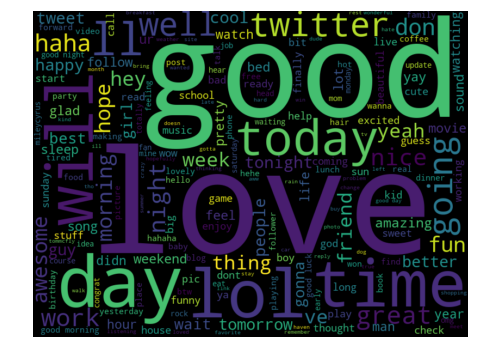



 Word cloud for negative tweets



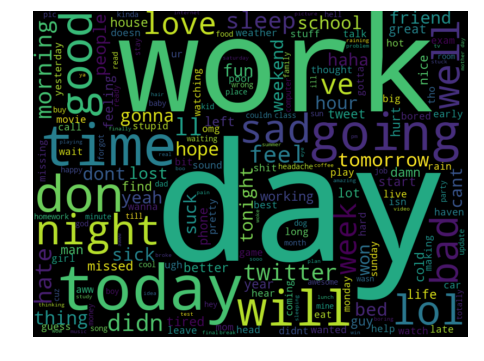

In [38]:

#show the word clouds
print('Word cloud for positive tweets\n')
plt.figure(figsize=(8, 6))
plt.imshow(poswordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print('\n\n Word cloud for negative tweets\n')
plt.figure(figsize=(8, 6))
plt.imshow(negwordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Looking at these we can see that both positive and negative tweets share a lot of the same word, but there are some differences that pop out. They both include the word 'Love,' but the it is relatively more frequent in the positive tweets. The same goes for the words 'good' and 'lol'. The word 'work' seems to feature prominently in negative tweets, but not in positive tweets. On to the airline tweets...

Since we have them labelled, let's create a bar chart to see how each ariline stacks up with positive or negative tweets.  

AxesSubplot(0.125,0.125;0.775x0.755)


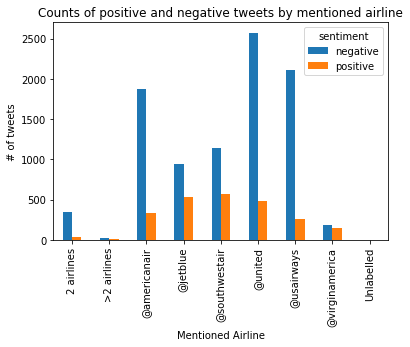

In [130]:
#isolate relevant data
chartdat=pd.crosstab(airTweets_clean['airline'], airTweets_clean["sentiment"])
barchart=chartdat.plot.bar(title="Counts of positive and negative tweets by mentioned airline")
barchart.set(ylabel="# of tweets", xlabel="Mentioned Airline")
print(barchart)

Wow. American, United and Us Airways are.... not well liked on twitter. From inspection we see that, not only are they the most mentioned, they have much higher proportion of negative tweets. Virgin Airlines is rarely mentioned compared to the other ones, but clearly has the highest proportion of positive tweets, though it is still less tha 50%. Let's move on to the modelling. Let's get a closer look ar those proportion of positive tweets by airline...

In [131]:
chartdat['pos_prop']=chartdat['positive']/(chartdat['negative']+chartdat['positive'])
print(chartdat)

sentiment       negative  positive  pos_prop
airline                                     
2 airlines           340        36  0.095745
>2 airlines           25         4  0.137931
@americanair        1869       331  0.150455
@jetblue             937       535  0.363451
@southwestair       1145       564  0.330018
@united             2573       482  0.157774
@usairways          2108       259  0.109421
@virginamerica       178       150  0.457317
Unlabelled             3         2  0.400000


Yup, as the chart suggested. Also, if more than airline is mentioned in a tweet, that person is not likely to be saying something positive. OK. On to the modelling...


## Model Preparation 
OK. First things first, let's get the data cleaned up a bit more. Then we'll generate features. Then we'll split them into training and testing sets. 

Let's start by removing the usernames (I would have done this sooner, but we needed them to identify the airlines). Then we'll lemmatize the tokens 

Let's start by using lemmatization to reduce the possible feauture space.

In [132]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()

def clean2(lst):
    
    #get rid of usernames
    string=' '.join(lst)
    usernames=re.findall('@[\w]*',string)
    z=[w for w in lst if not w in usernames]
    
    #lemmatize
    z=[lem.lemmatize(x) for x in z]
    return z

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [133]:
genTweets_clean['lemma_tokens']=genTweets_clean['filtered_tokens'].apply(lambda x: clean2(x))

OK, now' let's extract some features. We're just going to take a bag-of-words (BOW) approach. That is to say that we will create a matrix with each unique token in the dataset as a column and each observation is a row. The values in the matrix are a count of each token in each observation. We've already taken out some very common words, but now we'll also take out words that appear in too many or too few observations to be useful. If a feature appears in too many observations, it will have no disciminative power. If the word does not appear enough, it will not have enough observations to learn anything useful from it. After a little trial and error, we find that that an upper bound of 50% is a non-binding constraint on the feature space. As for lower bounds on occurences, let's say we need at least 10 observations to learn about a feature. 

In [307]:
#get the tokens in a for the bow vecrtorizer can use
def mkstring(lst): 
    return ' '.join(lst)

genTweets_clean['cleaner_text']=genTweets_clean['lemma_tokens'].apply(lambda x: mkstring(x))

from sklearn.feature_extraction.text import CountVectorizer
#define the vectorizer
bow_vectorizer = CountVectorizer(max_df=0.50, min_df=10)
# bag-of-words feature matrix
genTweet_feat = bow_vectorizer.fit_transform(genTweets_clean['cleaner_text'])
genTweet_feat

<200000x8665 sparse matrix of type '<class 'numpy.int64'>'
	with 934068 stored elements in Compressed Sparse Row format>

In [557]:
from sklearn.model_selection import train_test_split

y=genTweets['class'].replace(to_replace=4,value=1) #I don't like the 4's. I like 0,1 for binary data
X_train, X_test, y_train, y_test = train_test_split(genTweet_feat,y,test_size=0.3, random_state=101)

In [558]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [560]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, balanced_accuracy_score, precision_score, recall_score  

predictions = model.predict(X_test)
resultsDF = pd.DataFrame({'true':y_test, 'predicted':predictions})

accuracy= accuracy_score(predictions,y_test)*100
print('Accuracy: ', accuracy)

Accuracy:  73.84333333333333


Now let's apply it to the airline data. 

In [564]:
#do the same scondary cleaning and lemmatization (the lemmatization is especially important so that features are consistently interpretted)
airTweets_clean['lemma_tokens']=airTweets_clean['filtered_tokens'].apply(lambda x: clean2(x))

#get the tokens into a readable string format for the bow transform
airTweets_clean['cleaner_text']=airTweets_clean['lemma_tokens'].apply(lambda x: mkstring(x))

#get thh document-term matrix 
airTweet_X = bow_vectorizer.transform(airTweets_clean['cleaner_text'])

#Again, let's work with 0's and 1's
y_air=airTweets['sentiment'].replace({'negative':0, 'positive':1}) 

#Generate predictions
predictions_air = model.predict(airTweet_X)
resultsDF_air = pd.DataFrame({'true':y_air, 'predicted':predictions_air})

#Calculate accuracy
accuracy_air= accuracy_score(predictions_air,y_air)*100
roc_air = roc_auc_score(predictions_air,y_air)*100

print('Accuracy: ', accuracy_air)
print('\nROC: ',roc_air)



Accuracy:  75.23611472142795

ROC:  68.8503773885581


So, the model does.... not bad. 75% of the time it's right. That said, if it just classified all of them as negative it would be right ~80% of the time (but the data was trained on balanced data, so I'm not sure that is too relevant). 

Now let's build a second model to evaluate reasons for negative reviews. First we explore the negative reviews to see what we are working with. Let's start with a frequency chart 

In [544]:
#Isolate negative tweets in dataset
airTweets_clean_neg=airTweets_clean[airTweets_clean['sentiment']=='negative']
print(pd.crosstab(airTweets_clean_neg['sentiment'], 'count'),"\n")

neg_reason_freq=pd.crosstab(airTweets_clean_neg['negative_reason'], 'count')
print(neg_reason_freq)

col_0      count
sentiment       
negative   9178  

col_0                        count
negative_reason                   
Bad Flight                   580  
Can't Tell                   1190 
Cancelled Flight             847  
Customer Service Issue       2910 
Damaged Luggage              74   
Flight Attendant Complaints  481  
Flight Booking Problems      529  
Late Flight                  1665 
Lost Luggage                 724  
longlines                    178  


10 Categories is a bit unruly. Also, we have some very small ones. Let's combine thematically. We can combine the two-luggage related ones, let's put longlines in with customer service. 

In [545]:
airTweets_clean_neg['negative_reason'].replace({'longlines':'Customer Service Issue', 'Damaged Luggage': 'Luggage issue', 'Lost Luggage': 'Luggage issue'}, inplace=True)

neg_reason_freq=pd.crosstab(airTweets_clean_neg['negative_reason'], 'count')
print(neg_reason_freq)

col_0                        count
negative_reason                   
Bad Flight                   580  
Can't Tell                   1190 
Cancelled Flight             847  
Customer Service Issue       3088 
Flight Attendant Complaints  481  
Flight Booking Problems      529  
Late Flight                  1665 
Luggage issue                798  


OK. This looks fine. Let's generate a dictionary from the negative tweets and train a multi-class model. Through trial and error min_df of 20 gives us about 10 obs/feature (dimentionality rule of thumb). This is different from our first reasoning about min_df where we were just looking for features with enough supporting observations. Here we're conscious of the fact that we don't want a feature space that is too wide to be characterized by the observations. This was less of a problem when we were training on ~140K general observations. In this case we're training on ~6k, so we are more concerned with keeping the feature space below 600ish (we round and increment min_df by 5 because it's fewer trials and fewer errors).  

In [546]:
#define the vectorizer 
bow_vectorizer2 = CountVectorizer(max_df=0.50, min_df=20)

#get thh document-term matrix 
airTweet_neg_feat = bow_vectorizer2.fit_transform(airTweets_clean_neg['cleaner_text'])
airTweet_neg_feat

<9178x573 sparse matrix of type '<class 'numpy.int64'>'
	with 48423 stored elements in Compressed Sparse Row format>

In [555]:
#define the outcome
y_air_neg=airTweets_clean_neg['negative_reason'] 

#split the data 70/30 again
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(airTweet_neg_feat,y_air_neg,test_size=0.3, random_state=101)

#train the model
model = LogisticRegression()
model.fit(X_train_neg,y_train_neg)

#generate predictions
predictions_neg = model.predict(X_test_neg)
resultsDF_neg = pd.DataFrame({'true':y_test_neg, 'predicted':predictions_neg})

#Calculate and print accuracy
accuracy_neg= accuracy_score(predictions_neg,y_test_neg)*100
f1_neg= f1_score(predictions_neg,y_test_neg, labels=neg_reason_freq.index, average='weighted')*100
precision_neg = precision_score(predictions_neg, y_test_neg, labels = neg_reason_freq.index, average='weighted')*100
recall_neg= recall_score(predictions_neg,y_test_neg, labels=neg_reason_freq.index, average='weighted')*100


print('Accuracy: ', accuracy_neg)




Accuracy:  61.22004357298475


Lets' explore the the results a bit more

## Results

### What can public opinion say about the airline industry in 2015

The accuracy of our setinmaent model was ~75% when applied to the airline data. Not bad for a simple BOW analysis. Let's see what the data says about the airline industry. We start by plotting the proportion of 

AxesSubplot(0.125,0.125;0.775x0.755)
predicted       negative  positive    All  pos_prop
airline                                            
2 airlines           240       136    376  0.361702
>2 airlines           19        10     29  0.344828
@americanair        1482       718   2200  0.326364
@jetblue             735       737   1472  0.500679
@southwestair        966       743   1709  0.434757
@united             2001      1054   3055  0.345008
@usairways          1666       701   2367  0.296155
@virginamerica       155       173    328  0.527439
Unlabelled             2         3      5  0.600000
All                 7266      4275  11541  0.370419
0.37041850792825576


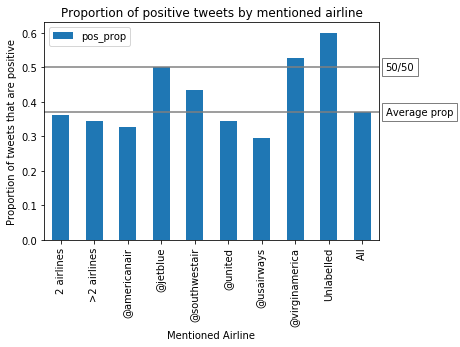

In [461]:
resultsDF_air['airline'] = airTweets_clean['airline']

resultsDF_air['predicted'].replace({1:'positive',0:'negative'}, inplace=True)

reschart=pd.crosstab(resultsDF_air['airline'], resultsDF_air['predicted'], margins=True)
reschart['pos_prop']=reschart['positive']/(reschart['All'])
resplot=reschart.plot.bar(y='pos_prop', title="Proportion of positive tweets by mentioned airline")
resplot.set(ylabel="Proportion of tweets that are positive", xlabel="Mentioned Airline")
avg_prop=reschart['positive'].sum()/(reschart['All'].sum())
resplot.axhline(avg_prop, color="gray")
resplot.text(1.02, avg_prop, "Average prop", va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5),
        transform=resplot.get_yaxis_transform())

resplot.axhline(0.5, color="gray")
resplot.text(1.02, 0.5, "50/50", va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5),
        transform=resplot.get_yaxis_transform())
print(resplot)
print(reschart)
print(avg_prop)

Well, off the bat, we can see that overall, most tweets about the US airline are not favourable. On average, the model found that only 37% of tweets were positive. Only two arilines, both budget airlines, had more positive than negative tweets: Virgin America and Jet Blue. Other than those two, Southwest, another budget airline, was the only other airline that was above average. US Airways had the most negative sentiment of major US airlines on Twitter. 

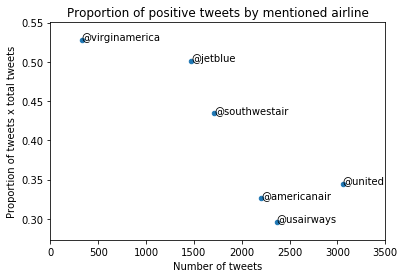

In [462]:
reschart2=reschart.drop(['2 airlines', '>2 airlines', 'All', 'Unlabelled'], axis=0)
resplot2=reschart2.plot.scatter(x='All', y='pos_prop', title="Proportion of positive tweets by mentioned airline")
resplot2.set(ylabel="Proportion of tweets x total tweets", xlabel="Number of tweets", xlim=(0,3500))
for i, txt in enumerate(reschart2.index):
    resplot2.annotate(txt, (reschart2.All.iat[i],reschart2.pos_prop.iat[i]))

Looking only at tweets that uniquely identify an airline, it seems like no news is good news. Only United Airways bucks this trend.... a little. It is the most tweeted at, but does not have the lowest proportion of predicted negative tweets, but it's still not good.  

Well, that's what the model results say. Let's look at the model itself:

In [463]:
#Assessing balance of Airline dataset 
air_sent=pd.crosstab(airTweets_clean['sentiment'], columns='count', margins=True)
bal=air_sent.loc['positive']['count']/air_sent.loc['All']['count']
print("Proportion of positive tweets in airline data: ", bal)

print('\n\nModel performance:\n\n Accuracy: ', accuracy_air)
print('\nBalanced accuracy: ',bal_accuracy_air)
print('\nROC: ',roc_air)

Proportion of positive tweets in airline data:  0.20474828870981718


Model performance:

 Accuracy:  75.23611472142795

Balanced accuracy:  68.8503773885581

ROC:  68.8503773885581


Originally it was surprising that the model performed better on the airline data than it did on the test set from the general tweets, but if we account for the fact that almost 80% of the tweets in the airline data were classified as negative, we see that our model was much more optimistic about the tweets than was justified. If we account for this imbalance in the data by weighting the accuracy by the proportions of the true states, we get a balanced accuracy of 68.85. Not great. Not as good as the model performed on the test data (~73%). This suggests that either the airline data had some specific, informative, features that were propbably not in the training data, or the language was used differently in the general tweets. Either way this suggests over fitting. Though it could not be that severe since the accuracy was only 73% in the orginial. 

One thing we could have done is do a bit more feature engineering. There is 'parts of speech' analysis which would have classified the words based on their function (noun, verb, etc). From here we could have created some features around sentence structure. For example, 'It could not have been better' vs 'It could have been better' and 'I am happy' vs 'I am not happy'. In this case, the token 'not' reverses the meaning, but by analyzing the order of words in a tweet, we maybe could have created some very informative features. Also, our n-grams were of length 1. We could have created more features by creating features that were two-words long. That would allow the model to consider 'so happy' and 'not happy' rather than just "so, "not" and "happy".     Let's turn our gaze to the reasons.   

### How did our model do for figuing out reasons for negative reviews?
Well, it did ok. An accuracy of 61% with eight categories is not too shabby, I think. Let's investigate the results a bit more.

Which reasons were predicted most accurately? 

 correct                      False  True  Total Pred       tpr  Train Freq  Test Freq    recall
predicted                                                                                      
Bad Flight                   70     71    141         0.503546  396         184        0.385870
Can't Tell                   254    202   456         0.442982  829         361        0.559557
Cancelled Flight             62     174   236         0.737288  610         237        0.734177
Customer Service Issue       354    660   1014        0.650888  2147        941        0.701382
Flight Attendant Complaints  44     36    80          0.450000  337         144        0.250000
Flight Booking Problems      45     57    102         0.558824  352         177        0.322034
Late Flight                  168    340   508         0.669291  1174        491        0.692464
Luggage issue                71     146   217         0.672811  579         219        

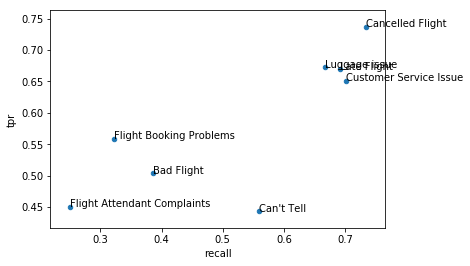

In [523]:
# neg_reason_train_freq=pd.crosstab(y_train_neg, columns='count')
neg_reason_test_freq=pd.crosstab(y_test_neg, columns='count')

                                 
resultsDF_neg['correct']=(resultsDF_neg['true']==resultsDF_neg['predicted'])
resultsDF_neg['incorrect']=(resultsDF_neg['true']!=resultsDF_neg['predicted'])
acc_chart_neg=pd.crosstab(resultsDF_neg['predicted'], resultsDF_neg['correct'])
acc_chart_neg['Total Pred']=(acc_chart_neg[True]+acc_chart_neg[False])
acc_chart_neg['tpr']=acc_chart_neg[True]/acc_chart_neg['Total Pred']
acc_chart_neg['Train Freq']=neg_reason_train_freq['count']
acc_chart_neg['Test Freq']=neg_reason_test_freq['count']
acc_chart_neg['recall']=acc_chart_neg[True]/acc_chart_neg['Test Freq']

print("Which reasons were predicted most accurately? \n\n",acc_chart_neg)
f1_plot_neg=acc_chart_neg.plot.scatter('recall', 'tpr')
for i, txt in enumerate(acc_chart_neg.index):
    f1_plot_neg.annotate(txt, (acc_chart_neg['recall'].iat[i],acc_chart_neg['tpr'].iat[i]))
    




The model did a pretty good job for identifying tweets about cancelled flights, Luggage issues, Customer service issues and late flights. 

We can see that 'Flight Attendant' and 'Can't Tell' have pretty poor tpr. Such that whenever the model classifies a tweet as one of those, it is more often wrong than right. There may be a couple issues including. The first is that they may just be hard to classify. Either the signal is weak (lots of variation in the feature space) or they are not easily separable in the feature space. I suspect the the problem for 'Can't Tell' is the former. This is because it has much higher recall. That means the model is OK at knowing a 'Can't Tell' when it sees it, but it also seems to be the catch  all for items that don't fit in other categories. 

To show this further we look at the confusion matricies. Since all the classes have different number of observations in the test set, we row-normalize so the boxes show the TPR in the diagonal.

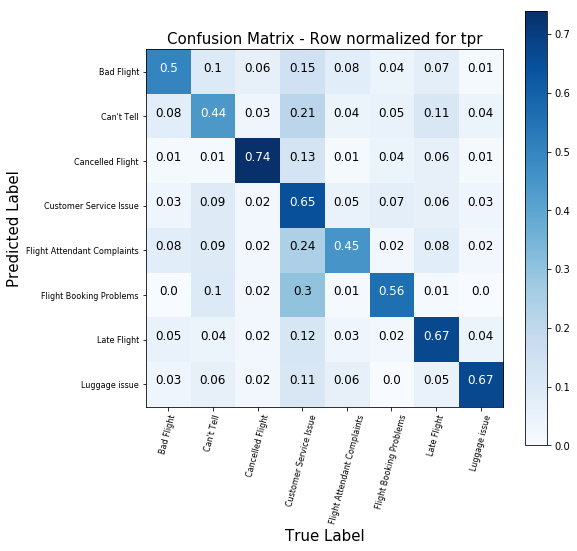

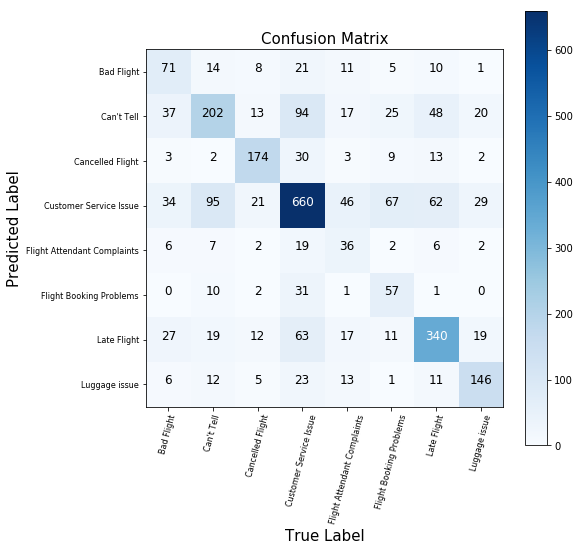

In [536]:
y=y_air_neg

cm = confusion_matrix(predictions_neg,y_test_neg, labels=acc_chart_neg.index)

row_sums = cm.sum(axis=1)
Ncm = (cm / row_sums[:, np.newaxis]).round(2)

col_sums = cm.sum(axis=0)
CNcm = (cm / col_sums[:, np.newaxis]).round(2)
CNcm=CNcm.transpose()


cmDF = pd.DataFrame()

for i, row in enumerate(acc_chart_neg.index):
    temp = {}
    for j, col in enumerate(acc_chart_neg.index): 
        temp[col]=cm[i,j]
    cmDF = cmDF.append(pd.DataFrame.from_dict({row:temp}, orient='index'))

#row normalized
plt.figure(figsize=(8,8))
plt.imshow(Ncm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Row normalized for tpr', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(y.unique()))
plt.xticks(tick_marks, acc_chart_neg.index, rotation=75, fontsize=8)
plt.yticks(tick_marks, acc_chart_neg.index, fontsize=8)
plt.xlabel('True Label', fontsize=15)
plt.ylabel('Predicted Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if Ncm[i][j] > 0.4:
            color = 'white'
        plt.text(j, i, format(Ncm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=12)
        
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(y.unique()))
plt.xticks(tick_marks, acc_chart_neg.index, rotation=75, fontsize=8)
plt.yticks(tick_marks, acc_chart_neg.index, fontsize=8)
plt.xlabel('True Label', fontsize=15)
plt.ylabel('Predicted Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] > 300:
            color = 'white'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=12)

To make more accurate models, again, we could do more to engineer more informative features. Stemming may have been good. Given the massive feature space, we may hve been been well-advised to undergo a multi-stage feature selection process, eliminating step-wise features until we are left with a smaller, better seperable feature space with only the most informative set of features.